In [2]:
import pandas as pd, numpy as np, datetime as dt, os, operator
import sqlalchemy as sql, seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN

In [4]:
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam

In [397]:
engine = sql.create_engine("sqlite:///../src/data/music.db")
with engine.connect() as con:
    attributes = pd.read_sql("SELECT * FROM attributes", con=con)

In [398]:
attributes.loc[attributes.timesignature.isna(), 'timesignature'] = 1  

In [128]:
classifies_df = attributes.loc[:, ["Song", "Performer", "danceability", "acousticness","energy", "speechiness", 'instrumentalness', 'liveness', 'valence', # [0, 1] continuous variables
'tempo', "loudness", 'duration', # specific intervals continuous variables 
'timesignature', 'mode','explicit', "key","chart", 'genre_super']] # categorical variables

In [129]:
classifies_df = classifies_df.assign(genre_super = lambda x: x.genre_super.apply(lambda g: g if g not in ["empty", "missing"] else "other"))

In [130]:
classifies_df = classifies_df.dropna()

In [131]:
X = classifies_df.iloc[:, 2:-2].values
y = classifies_df.iloc[:, -2].values

In [132]:
1 - classifies_df.iloc[:, -2].mean()

0.6216277902040444

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5, shuffle=True)

In [134]:
rf_chart = RandomForestClassifier(n_estimators=200)
rf_chart = rf_chart.fit(X_train, y_train)

In [135]:
clf_chart = tree.DecisionTreeClassifier()
clf_chart = clf_chart.fit(X_train, y_train)

In [136]:
clf_sv_chart = svm.SVC()
clf_sv_chart = clf_sv_chart.fit(X_train, y_train)

In [137]:
knn_chart = KNeighborsClassifier(2)
knn_chart = knn_chart.fit(X_train, y_train)

In [138]:
for n, m in zip(["RANDOM FOREST", "DECISION TREE", "SUPPORT VECTOR", "K-Nearest Neighbors"], [rf_chart, clf_chart, clf_sv_chart, knn_chart]):
    print(f"{n} : {m.score(X_test, y_test)*100}% Correctly Classified")

RANDOM FOREST : 62.25449515905947% Correctly Classified
DECISION TREE : 55.43568464730291% Correctly Classified
SUPPORT VECTOR : 62.32365145228216% Correctly Classified
K-Nearest Neighbors : 58.90733056708161% Correctly Classified


In [140]:
chart_class_df = pd.DataFrame(zip(knn_chart.predict(X_test), clf_chart.predict(X_test), rf_chart.predict(X_test), clf_sv_chart.predict(X_test), y_test), columns=["knn", "decision_tree", "random_forest", "svm","chart"])
chart_class_df= chart_class_df.assign(knn_bin = lambda x: (x.knn == x.chart).astype("int"))
chart_class_df= chart_class_df.assign(dt_bin = lambda x: (x.decision_tree == x.chart).astype("int"))
chart_class_df= chart_class_df.assign(rf_bin = lambda x: (x.random_forest == x.chart).astype("int"))
chart_class_df= chart_class_df.assign(svm_bin = lambda x: (x.svm == x.chart).astype("int"))
chart_class_df = chart_class_df.assign(preds = lambda x: x.iloc[:, -4:].sum(axis=1))

In [141]:
chart_class_df.groupby("preds").mean()

,knn,decision_tree,random_forest,svm,chart,knn_bin,dt_bin,rf_bin,svm_bin
preds,,,,,,,,,
0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
1,0.237455,0.669355,0.200717,0.0,0.946237,0.183692,0.615591,0.146953,0.053763
2,0.460352,0.914097,0.625551,0.0,0.470264,0.461454,0.470264,0.538546,0.529736
3,0.255973,0.677474,0.134812,0.0,0.034130,0.778157,0.356655,0.899317,0.965870
4,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000,1.000000


In [142]:
chart_class_df.groupby("preds").count()

,knn,decision_tree,random_forest,svm,chart,knn_bin,dt_bin,rf_bin,svm_bin
preds,,,,,,,,,
0,1181,1181,1181,1181,1181,1181,1181,1181,1181
1,1116,1116,1116,1116,1116,1116,1116,1116,1116
2,908,908,908,908,908,908,908,908,908
3,1758,1758,1758,1758,1758,1758,1758,1758,1758
4,2267,2267,2267,2267,2267,2267,2267,2267,2267


In [143]:
chart_class_df.groupby("random_forest").mean()

,knn,decision_tree,svm,chart,knn_bin,dt_bin,rf_bin,svm_bin,preds
random_forest,,,,,,,,,
0.0,0.150782,0.348008,0.0,0.356717,0.603451,0.561684,0.643283,0.643283,2.451701
1.0,0.192420,0.592809,0.0,0.497570,0.502430,0.510204,0.497570,0.502430,2.012634


In [144]:
chart_class_df.groupby("decision_tree").mean()

,knn,random_forest,svm,chart,knn_bin,dt_bin,rf_bin,svm_bin,preds
decision_tree,,,,,,,,,
0.0,0.150829,0.093904,0.0,0.356118,0.602420,0.643882,0.640968,0.643882,2.531152
1.0,0.166185,0.220376,0.0,0.410043,0.567558,0.410043,0.592847,0.589957,2.160405


In [145]:
# Percentages each model classified songs as charters vs. their actual rate (i.e., chart variable)
chart_class_df.loc[:, ["knn", "decision_tree", "random_forest", "svm","chart"]].mean()

knn              0.156708
decision_tree    0.382849
random_forest    0.142324
svm              0.000000
chart            0.376763
dtype: float64

In [146]:
chart_class_df.describe()

,knn,decision_tree,random_forest,svm,chart,knn_bin,dt_bin,rf_bin,svm_bin,preds
count,7230.000000,7230.000000,7230.000000,7230.0,7230.000000,7230.000000,7230.000000,7230.000000,7230.000000,7230.000000
mean,0.156708,0.382849,0.142324,0.0,0.376763,0.589073,0.554357,0.622545,0.623237,2.389212
std,0.363551,0.486116,0.349406,0.0,0.484608,0.492036,0.497071,0.484784,0.484608,1.467627
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000
75%,0.000000,1.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000
max,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [147]:
genre_dict = {g:i for i, g in zip(range(1, 15), classifies_df.genre_super.unique())}

In [148]:
genre_test = classifies_df.assign(genre_class = lambda x: x.genre_super.apply(lambda g: genre_dict[g]))

In [152]:
y_2 = genre_test.genre_class.values
X_2 = genre_test.iloc[:, 2:17].values

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, random_state=12, test_size=0.33,shuffle=True)

In [155]:
clf_genre = tree.DecisionTreeClassifier()
clf_genre = clf_genre.fit(X_train, y_train)

In [156]:
rf_genre = RandomForestClassifier(n_estimators=200)
rf_genre = rf_genre.fit(X_train, y_train)

In [157]:
knn_genre = KNeighborsClassifier(14)
knn_genre = knn_genre.fit(X_train, y_train)

In [158]:
clf_sv_genre = svm.SVC()
clf_sv_genre = clf_sv_genre.fit(X_train, y_train)

In [159]:
for n, m in zip(["RANDOM FOREST", "DECISION TREE", "SUPPORT VECTOR", "K-Nearest Neighbors"], [rf_genre, clf_genre, clf_sv_genre, knn_genre]):
    print(f"{n} : {m.score(X_test, y_test)*100}% Correctly Classified")

RANDOM FOREST : 52.807745504840945% Correctly Classified
DECISION TREE : 37.56569847856155% Correctly Classified
SUPPORT VECTOR : 29.322268326417706% Correctly Classified
K-Nearest Neighbors : 26.362378976486863% Correctly Classified


In [37]:
# scale non-[0,1] intervals to [0,1] {tempo, duration, loudness}
# scale categorical attributes to [0, 1] by category number / max category number
# See if better predictions are possible with scaled variables

In [162]:
classifies_df = classifies_df.assign(timesignature = lambda x: x.timesignature.apply(lambda f: f / x.timesignature.max()))\
    .assign(tempo = lambda x: x.tempo.apply(lambda j: j/x.tempo.max()))\
        .assign(duration = lambda x: x.duration.apply(lambda d: d / x.duration.max()))\
            .assign(loudness = lambda x: x.loudness.apply(lambda l: l / x.loudness.min()))\
                .assign(key = lambda x: x.key.apply(lambda k: k / x.key.max()))

In [163]:
genre_test = classifies_df.assign(genre_class = lambda x: x.genre_super.apply(lambda g: genre_dict[g]))

In [164]:
X = classifies_df.iloc[:, 2:-2].values
y = classifies_df.iloc[:, -2].values

In [165]:
1 - classifies_df.iloc[:, -2].mean()

0.6216277902040444

In [166]:
# Reruning chart classification with scaled categorical attributes

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5, shuffle=True)

In [168]:
rf_chart = RandomForestClassifier(n_estimators=200)
rf_chart = rf_chart.fit(X_train, y_train)

In [169]:
clf_chart = tree.DecisionTreeClassifier()
clf_chart = clf_chart.fit(X_train, y_train)

In [170]:
clf_sv_chart = svm.SVC()
clf_sv_chart = clf_sv_chart.fit(X_train, y_train)

In [171]:
knn_chart = KNeighborsClassifier(2)
knn_chart = knn_chart.fit(X_train, y_train)

In [172]:
for n, m in zip(["RANDOM FOREST", "DECISION TREE", "SUPPORT VECTOR", "K-Nearest Neighbors"], [rf_chart, clf_chart, clf_sv_chart, knn_chart]):
    print(f"{n} : {m.score(X_test, y_test)*100}% Correctly Classified")

RANDOM FOREST : 62.10235131396957% Correctly Classified
DECISION TREE : 55.10373443983403% Correctly Classified
SUPPORT VECTOR : 62.3789764868603% Correctly Classified
K-Nearest Neighbors : 58.672199170124486% Correctly Classified


In [187]:
y_2 = genre_test.genre_class.values
X_2 = genre_test.iloc[:, 2:17].values

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, random_state=12, test_size=0.33,shuffle=True)

In [189]:
clf_genre = tree.DecisionTreeClassifier()
clf_genre = clf_genre.fit(X_train, y_train)

In [190]:
rf_genre = RandomForestClassifier(n_estimators=200)
rf_genre = rf_genre.fit(X_train, y_train)

In [191]:
knn_genre = KNeighborsClassifier(14)
knn_genre = knn_genre.fit(X_train, y_train)

In [192]:
clf_sv_genre = svm.SVC()
clf_sv_genre = clf_sv_genre.fit(X_train, y_train)

In [193]:
for n, m in zip(["RANDOM FOREST", "DECISION TREE", "SUPPORT VECTOR", "K-Nearest Neighbors"], [rf_genre, clf_genre, clf_sv_genre, knn_genre]):
    print(f"{n} : {m.score(X_test, y_test)*100}% Correctly Classified")

RANDOM FOREST : 52.54495159059475% Correctly Classified
DECISION TREE : 37.28907330567082% Correctly Classified
SUPPORT VECTOR : 49.25311203319502% Correctly Classified
K-Nearest Neighbors : 46.86030428769018% Correctly Classified


In [194]:
genre_class_df = pd.DataFrame(zip(knn_genre.predict(X_test), clf_genre.predict(X_test), rf_genre.predict(X_test), clf_sv_genre.predict(X_test), y_test), columns=["knn", "decision_tree", "random_forest", "svm","genre"])
genre_class_df= genre_class_df.assign(knn_bin = lambda x: (x.knn == x.genre).astype("int"))
genre_class_df= genre_class_df.assign(dt_bin = lambda x: (x.decision_tree == x.genre).astype("int"))
genre_class_df= genre_class_df.assign(rf_bin = lambda x: (x.random_forest == x.genre).astype("int"))
genre_class_df= genre_class_df.assign(svm_bin = lambda x: (x.svm == x.genre).astype("int"))
genre_class_df = genre_class_df.assign(preds = lambda x: x.iloc[:, -4:].sum(axis=1))

In [195]:
genre_parse = {v:k for k,v in genre_dict.items()}

In [196]:
genre_class_df.assign(genre_name = lambda x: x.genre.apply(lambda t: genre_parse[t])).groupby("genre_name").mean()

,knn,decision_tree,random_forest,svm,genre,knn_bin,dt_bin,rf_bin,svm_bin,preds
genre_name,,,,,,,,,,
christian,2.846154,4.384615,3.115385,2.903846,8.0,0.000000,0.019231,0.000000,0.000000,0.019231
country,2.696677,3.874598,2.801715,2.661308,3.0,0.487674,0.381565,0.605573,0.469453,1.944266
electronic,3.765013,5.347258,4.052219,3.370757,10.0,0.104439,0.185379,0.146214,0.080940,0.516971
indie,2.705426,4.899225,2.953488,2.744186,4.0,0.023256,0.023256,0.015504,0.000000,0.062016
jazz,2.812500,4.625000,2.375000,3.187500,13.0,0.000000,0.000000,0.000000,0.000000,0.000000
latin,3.162011,4.972067,3.011173,2.497207,11.0,0.044693,0.083799,0.033520,0.000000,0.162011
metal,4.447917,5.177083,4.770833,4.500000,9.0,0.000000,0.135417,0.031250,0.000000,0.166667
other,2.860759,4.860759,3.151899,3.227848,7.0,0.012658,0.037975,0.025316,0.050633,0.126582
pop,3.014173,4.388976,3.102362,2.897113,2.0,0.558530,0.352231,0.586877,0.674016,2.171654


In [197]:
genre_class_df = genre_class_df.assign(genre_name = lambda x: x.genre.apply(lambda t: genre_parse[t]))

In [198]:
genre_classed = pd.DataFrame(zip(knn_genre.predict(classifies_df.iloc[:, 2:-1].values), clf_genre.predict(classifies_df.iloc[:, 2:-1].values), rf_genre.predict(classifies_df.iloc[:, 2:-1].values), clf_sv_genre.predict(classifies_df.iloc[:, 2:-1].values), y_2), columns=["knn", "decision_tree", "random_forest", "svm","genre"])

In [199]:
genre_classed.knn=genre_classed.knn.apply(lambda x: genre_parse[x])
genre_classed.svm=genre_classed.svm.apply(lambda x: genre_parse[x])
genre_classed.decision_tree=genre_classed.decision_tree.apply(lambda x: genre_parse[x])
genre_classed.random_forest=genre_classed.random_forest.apply(lambda x: genre_parse[x])
genre_classed.genre = genre_classed.genre.apply(lambda x: genre_parse[x])

In [200]:
df_class_and_attr = pd.concat([genre_test.reset_index(drop=True), genre_classed], axis=1).drop("genre", axis=1)

In [201]:
df_class_and_attr

,Song,Performer,danceability,acousticness,energy,speechiness,instrumentalness,liveness,valence,tempo,...,mode,explicit,key,chart,genre_super,genre_class,knn,decision_tree,random_forest,svm
0,i'm your angel,r. kelly & celine dion,0.620,0.66900,0.504,0.0301,0.000000,0.1100,0.266,0.521623,...,1.0,0.0,0.000000,1.0,r&b,1,pop,pop,pop,pop
1,nobody's supposed to be here,deborah cox,0.662,0.20200,0.531,0.0361,0.000012,0.5950,0.399,0.555305,...,1.0,0.0,0.727273,1.0,r&b,1,r&b,r&b,r&b,pop
2,lately,divine,0.582,0.12300,0.665,0.0517,0.000000,0.1200,0.444,0.566235,...,1.0,0.0,0.181818,1.0,pop,2,country,soundtrack,pop,country
3,...baby one more time,britney spears,0.759,0.20200,0.699,0.0307,0.000131,0.4430,0.907,0.430331,...,0.0,0.0,0.000000,1.0,pop,2,pop,pop,pop,pop
4,because of you,98 degrees,0.732,0.34100,0.603,0.0271,0.000000,0.1130,0.514,0.483742,...,1.0,0.0,0.000000,1.0,pop,2,pop,pop,pop,country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21902,Soon as I Get Home,Faith Evans,0.652,0.51900,0.498,0.0413,0.000000,0.1490,0.336,0.556157,...,1.0,0.0,1.000000,0.0,r&b,1,country,r&b,r&b,pop
21903,Be Without You - Kendu Mix,Mary J. Blige,0.726,0.07170,0.700,0.0998,0.000000,0.2620,0.673,0.678451,...,0.0,1.0,0.181818,0.0,r&b,1,rap,r&b,r&b,rap
21904,Swing My Way,K.P. & Envyi,0.557,0.00323,0.865,0.1390,0.000000,0.1060,0.501,0.645227,...,0.0,0.0,0.818182,0.0,rap,6,pop,rock,pop,pop
21905,Yoü And I,Lady Gaga,0.518,0.07500,0.709,0.0476,0.000000,0.0935,0.514,0.588293,...,1.0,0.0,0.181818,1.0,pop,2,country,pop,pop,country


In [202]:
df_class_and_attr[lambda g: g.genre_super == "pop"].groupby(["genre_super", "random_forest"]).count().iloc[:, :1].sort_values("Song", ascending=False)

Song
genre_super random_forest      
pop         pop            4983
            rap             286
            country         241
            rock            150
            r&b              68
            electronic       23
            latin             9
            soundtrack        6
            indie             4

In [203]:
df_class_and_attr[lambda g: g.genre_super == "pop"].groupby(["genre_super", "knn"]).count().iloc[:, :1].sort_values("Song", ascending=False)

Song
genre_super knn             
pop         pop         3563
            country      834
            rap          803
            rock         271
            r&b          216
            electronic    50
            latin         15
            soundtrack    10
            indie          7
            other          1

In [204]:
df_class_and_attr[lambda g: g.genre_super == "pop"].groupby(["genre_super", "svm"]).count().iloc[:, :1].sort_values("Song", ascending=False)

Song
genre_super svm             
pop         pop         3912
            rap          880
            country      673
            rock         269
            r&b           21
            electronic    13
            other          2

In [205]:
df_class_and_attr[lambda g: g.genre_super == "pop"].groupby(["genre_super", "decision_tree"]).count().iloc[:, :1].sort_values("Song", ascending=False)

Song
genre_super decision_tree      
pop         pop            4536
            country         270
            rap             256
            rock            188
            r&b             158
            electronic      128
            soundtrack       70
            latin            67
            indie            32
            metal            22
            christian        16
            other            16
            reggae            9
            jazz              2

In [214]:
attr_class = attributes.merge(df_class_and_attr.loc[:, ["Song", "Performer", "genre_class", "knn", "decision_tree", "random_forest", "svm"]], "left", on=["Song", "Performer"])

In [215]:
#attr_class.to_csv("class_and_attr.csv", index=False)

In [216]:
attr_class

,Song,Performer,SongID,id,danceability,energy,key,loudness,mode,speechiness,...,genre,genre_super,transform,bill_popularity,scaled_popularity,genre_class,knn,decision_tree,random_forest,svm
0,i'm your angel,r. kelly & celine dion,i'm your angelr. kelly & celine dion,0QWFiyhOqFu9RP8qzP6z5L,0.620,0.504,0.0,-7.260,1.0,0.0301,...,[],r&b,1.135822,1563.0,70.0,1.0,pop,pop,pop,pop
1,nobody's supposed to be here,deborah cox,nobody's supposed to be heredeborah cox,51QxenFmXlJXUN9mpvxlaL,0.662,0.531,8.0,-5.300,1.0,0.0361,...,"['canadian pop', 'hip pop', 'neo soul', 'new j...",r&b,1.537228,2564.0,76.0,1.0,r&b,r&b,r&b,pop
2,lately,divine,latelydivine,5pgkdQi8HMQHYrJCB4GLsA,0.582,0.665,2.0,-6.992,1.0,0.0517,...,['fijian pop'],pop,1.459904,2338.0,75.0,2.0,country,soundtrack,pop,country
3,...baby one more time,britney spears,...baby one more timebritney spears,3MjUtNVVq3C8Fn0MP3zhXa,0.759,0.699,0.0,-5.745,0.0,0.0307,...,"['dance pop', 'pop', 'post-teen pop']",pop,1.589533,2727.0,77.0,2.0,pop,pop,pop,pop
4,because of you,98 degrees,because of you98 degrees,25tmiXojR7whvZDz3LpMb2,0.732,0.603,0.0,-7.624,1.0,0.0271,...,"['boy band', 'dance pop']",pop,1.245684,1797.0,72.0,2.0,pop,pop,pop,country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21924,Swing My Way,K.P. & Envyi,swing my wayk.p. & envyi,1DwrNN815hUHka1Z7qtvcM,0.557,0.865,9.0,-6.075,0.0,0.1390,...,['atlanta bass'],rap,NaN,NaN,NaN,6.0,pop,rock,pop,pop
21925,Yoü And I,Lady Gaga,you and ilady gaga,6rkAY9rk1NTFB94QxG3LJR,0.518,0.709,2.0,-5.234,1.0,0.0476,...,['pop'],pop,1.087257,1468.0,69.0,2.0,country,pop,pop,country
21926,Ta Da,Lil' Mo,ta dalil' mo,2fSDr3jBjwJsHBWwvvezgj,0.838,0.599,6.0,-5.398,1.0,0.1570,...,['r&b'],r&b,-1.273040,20.0,33.0,1.0,pop,r&b,r&b,pop
21927,hell of a life,t.i.,hell of a lifet.i.,None,NaN,NaN,NaN,NaN,NaN,NaN,...,None,rap,-0.863757,55.0,39.0,NaN,NaN,NaN,NaN,NaN


In [418]:
# Can I improve either classification by using Spotify's popularity Metric

In [419]:
classifies_df_2 = classifies_df.merge(attributes.loc[:, ["Song", "Performer", "popularity"]], "inner", on=["Song", "Performer"])

In [474]:
X = classifies_df_2.loc[:, ["danceability",	"acousticness",	"energy", "speechiness", "instrumentalness", "liveness", "valence",	"tempo", "loudness", "popularity","duration", "timesignature", "mode", "explicit", "key"]].values
y = classifies_df_2.loc[:, "chart"].values

In [475]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=51, shuffle=True)

In [476]:
rf_chart = RandomForestClassifier(n_estimators=200)
rf_chart = rf_chart.fit(X_train, y_train)

In [477]:
clf_chart = tree.DecisionTreeClassifier()
clf_chart = clf_chart.fit(X_train, y_train)

In [478]:
clf_sv_chart = svm.SVC()
clf_sv_chart = clf_sv_chart.fit(X_train, y_train)

In [479]:
knn_chart = KNeighborsClassifier(2)
knn_chart = knn_chart.fit(X_train, y_train)

In [480]:
for n, m in zip(["RANDOM FOREST", "DECISION TREE", "SUPPORT VECTOR", "K-Nearest Neighbors"], [rf_chart, clf_chart, clf_sv_chart, knn_chart]):
    print(f"{n} : {m.score(X_test, y_test)*100}% Correctly Classified")

RANDOM FOREST : 66.20575221238938% Correctly Classified
DECISION TREE : 56.27765486725663% Correctly Classified
SUPPORT VECTOR : 64.17311946902655% Correctly Classified
K-Nearest Neighbors : 61.11725663716814% Correctly Classified


In [481]:
X_2 = classifies_df_2.loc[:, ["danceability",	"acousticness",	"energy", "speechiness", "instrumentalness", "liveness", "valence",	"tempo", "loudness", "popularity","duration", "timesignature", "mode", "explicit", "key", "chart"]].values
y_2 = classifies_df_2.loc[:, "genre_super"].values

In [483]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.33, random_state=51, shuffle=True)

In [484]:
rf_genre_w_pop = RandomForestClassifier(n_estimators=200)
rf_genre_w_pop = rf_genre_w_pop.fit(X_train, y_train)

In [485]:
clf_genre_w_pop = tree.DecisionTreeClassifier()
clf_genre_w_pop = clf_genre_w_pop.fit(X_train, y_train)

In [486]:
clf_sv_genre_w_pop = svm.SVC()
clf_sv_genre_w_pop = clf_sv_genre_w_pop.fit(X_train, y_train)

In [487]:
knn_genre_w_pop = KNeighborsClassifier(14)
knn_genre_w_pop = knn_genre_w_pop.fit(X_train, y_train)

In [488]:
# Helps Tree Classifiers but Decrease Efficency of SVM and KNN; Since the trees overall give me the best predictions across different variable combinations, I will use Spot's popularity for my final classification
for n, m in zip(["RANDOM FOREST", "DECISION TREE", "SUPPORT VECTOR", "K-Nearest Neighbors"], [rf_genre_w_pop, clf_genre_w_pop, clf_sv_genre_w_pop, knn_genre_w_pop]):
    print(f"{n} : {m.score(X_test, y_test)*100}% Correctly Classified")

RANDOM FOREST : 53.91316371681416% Correctly Classified
DECISION TREE : 39.0625% Correctly Classified
SUPPORT VECTOR : 42.46404867256637% Correctly Classified
K-Nearest Neighbors : 43.33517699115044% Correctly Classified


In [239]:
# Songs that Live on (brief appearence on the billboard chart with current high popularity)
# Descrepancy between the normal dist of popularity and semi-normal transform of the exponential cumulative bill popularity 
attr_class.sort_values(["bill_popularity"], ascending=False).dropna().assign(g = lambda x: x.scaled_popularity - x.popularity).sort_values("g").loc[:, ["Song", "Performer", "bill_popularity", "scaled_popularity", "popularity","g"]].head(25)

,Song,Performer,bill_popularity,scaled_popularity,popularity,g
5947,like i can,sam smith,4.0,25.0,86.0,-61.0
8079,she,harry styles,2.0,23.0,77.0,-54.0
6411,nights,frank ocean,3.0,24.0,78.0,-54.0
7826,summer days,martin garrix featuring macklemore & patrick s...,1.0,21.0,75.0,-54.0
6562,hate u love u,olivia o'brien,2.0,23.0,76.0,-53.0
5667,the days,avicii,23.0,33.0,86.0,-53.0
8131,otro trago,sech featuring darell,1.0,21.0,73.0,-52.0
7931,love me,lil tecca,4.0,25.0,77.0,-52.0
2211,ella y yo,aventura featuring don omar,4.0,25.0,77.0,-52.0
6587,dancing on my own,calum scott,15.0,31.0,82.0,-51.0


In [241]:
# The Songs We've Forgotten (on Spotify but whose popularity as told by the song's time on the chart has the largest descrepancy vs. their Spotify Popularity today)
attr_class.sort_values(["bill_popularity"], ascending=False).dropna().assign(g = lambda x: x.scaled_popularity - x.popularity).sort_values("g", ascending=False).loc[:, ["Song", "Performer","bill_popularity", "scaled_popularity", "popularity","g"]].head(25)

,Song,Performer,bill_popularity,scaled_popularity,popularity,g
1262,miss you,aaliyah,2529.0,76.0,2.0,74.0
3744,your love is my drug,ke$ha,2002.0,73.0,0.0,73.0
479,try again,aaliyah,2699.0,77.0,5.0,72.0
4147,blow,ke$ha,1916.0,72.0,0.0,72.0
3011,bust it baby part 2,plies featuring ne-yo,1728.0,71.0,0.0,71.0
4101,we r who we r,ke$ha,1770.0,71.0,4.0,67.0
3745,take it off,ke$ha,1371.0,68.0,1.0,67.0
2632,2 step,unk,1242.0,67.0,0.0,67.0
2257,for you i will (confidence),teddy geiger,1106.0,66.0,0.0,66.0
1049,pass the courvoisier part ii,busta rhymes featuring p. diddy & pharrell,1349.0,68.0,3.0,65.0


In [242]:
attr_class.dropna()[lambda x: x.bill_popularity >= 1000].sort_values('bill_popularity', ascending=False).value_counts("genre_super")

genre_super
pop           814
rap           538
r&b           229
country       204
rock          173
electronic     72
metal          12
latin          11
indie           9
soundtrack      8
reggae          5
missing         4
christian       3
jazz            2
other           1
empty           1
dtype: int64

In [243]:
attr_class.release_date = pd.to_datetime(attr_class.release_date)

In [245]:
# Explicitness in Overall Music by Decades
attr_class[lambda x: ((x.release_date >= dt.datetime(1999, 1, 1))&(x.release_date <= dt.datetime(2009, 12, 31)))].value_counts("explicit", True)

explicit
0.0    0.788605
1.0    0.211395
dtype: float64

In [247]:
# Explicitness in Popular Music Matched That of Overall Music Trends
attr_class[lambda x: ((x.release_date >= dt.datetime(1999, 1, 1))&(x.release_date <= dt.datetime(2009, 12, 31))&(x.chart == 1.0))].value_counts("explicit", True)

explicit
0.0    0.782609
1.0    0.217391
dtype: float64

In [248]:
# Music as a Whole Has Become More Explicit
attr_class[lambda x: ((x.release_date >= dt.datetime(2010, 1, 1))&(x.release_date <= dt.datetime(2019, 12, 31)))].value_counts("explicit", True)

explicit
0.0    0.652982
1.0    0.347018
dtype: float64

In [249]:
# Popular Music Is More Explicit Now Than Before 
attr_class[lambda x: ((x.release_date >= dt.datetime(2010, 1, 1))&(x.release_date <= dt.datetime(2019, 12, 31))&(x.chart == 1.0))].value_counts("explicit", True)

explicit
0.0    0.617888
1.0    0.382112
dtype: float64

In [251]:
# We know that more rap music makes up the chart, which is the most explicit genre. Is rap now more explicit than previously?
attr_class[lambda x: ((x.release_date >= dt.datetime(1999, 1, 1))&(x.release_date <= dt.datetime(2009, 12, 31))&(x.genre_super == "rap"))].value_counts("explicit", True)

explicit
1.0    0.735714
0.0    0.264286
dtype: float64

In [252]:
# Rap Songs as a Whole Have Become More Explicit. Possible Reasons?
# Growth in Popularity as a Genre Has Stopped Censoring or creation of radio friendly / 'clean' hits
# Less prevalence of clean rappers, those whose style is based on not cursing
# Streaming's Rise Has Allowed Popularity To More Match Consumption (counting plays vs. Sales)
attr_class[lambda x: ((x.release_date >= dt.datetime(2010, 1, 1))&(x.release_date <= dt.datetime(2019, 12, 31))&(x.genre_super == "rap"))].value_counts("explicit", True)

explicit
1.0    0.87744
0.0    0.12256
dtype: float64

In [254]:
# Genre Makeup of Songs through 1999 to 2019
attr_class[lambda x: ((x.release_date >= dt.datetime(1999, 1, 1))&(x.release_date <= dt.datetime(2009, 12, 31)))].value_counts("genre_super", True)

genre_super
pop           0.245797
rap           0.217933
rock          0.146793
country       0.138232
r&b           0.103985
electronic    0.035181
soundtrack    0.025685
metal         0.024751
latin         0.021326
indie         0.015567
christian     0.009029
empty         0.006071
reggae        0.005137
missing       0.002179
jazz          0.001401
other         0.000934
dtype: float64

In [256]:
# Genre Makeup of Songs through 2010 to 2019
# Latin, Rap and Electronic have all Made an Increase while R&B and Rock Have Seen A Decrease
attr_class[lambda x: ((x.release_date >= dt.datetime(2010, 1, 1))&(x.release_date <= dt.datetime(2019, 12, 31)))].value_counts("genre_super", True)

genre_super
pop           0.287289
rap           0.286631
country       0.121102
electronic    0.065817
rock          0.065241
r&b           0.057178
soundtrack    0.043357
latin         0.029947
indie         0.016125
empty         0.009790
metal         0.006993
christian     0.005430
reggae        0.002468
missing       0.001563
other         0.000658
jazz          0.000411
dtype: float64

In [259]:
# Beyond Sample Size, even with an additional year here, the billboard chart experiences more turnover on songs that chart in the past decade than the preceding decade
attr_class[lambda x: ((x.release_date >= dt.datetime(1999, 1, 1))&(x.release_date <= dt.datetime(2009, 12, 31)))].value_counts("chart")

chart
1.0    3473
0.0    2951
dtype: int64

In [260]:
attr_class[lambda x: ((x.release_date >= dt.datetime(2010, 1, 1))&(x.release_date <= dt.datetime(2019, 12, 31)))].value_counts("chart")

chart
0.0    7638
1.0    4517
dtype: int64

In [273]:
attr_class = attr_class.assign(release_year = lambda x: x.release_date.apply(lambda r: r.year)).assign(half = lambda x: x.release_year.apply(lambda a: 1 if a < 2010 else 2))

In [278]:
attr_class.groupby("half").mean().loc[:, ["valence","popularity", "bill_popularity"]]

,valence,popularity,bill_popularity
half,,,
1,0.553836,50.442485,795.379930
2,0.479955,53.490141,597.532547


In [282]:
attr_class.groupby(['half', 'genre_super']).mean().sort_index(level=1).loc[:, ['popularity', 'chart', 'bill_popularity']]

,,popularity,chart,bill_popularity
half,genre_super,,,
1,christian,41.957746,0.225352,364.625000
2,christian,49.351351,0.108108,308.250000
1,country,44.224057,0.559748,612.830056
2,country,48.495857,0.474187,590.149194
1,electronic,47.400000,0.284615,634.459459
2,electronic,52.890845,0.194836,844.234940
1,empty,23.830189,0.018868,73.000000
2,empty,17.921260,0.221429,211.000000
1,indie,50.389937,0.157233,491.240000


In [291]:
# Charting Songs Counts
attr_class[lambda x: (x.chart > 0)&(x.half==1)].groupby(['half', 'genre_super']).count().sort_index(level=1)

Song  Performer  SongID   id  danceability  energy  key  \
half genre_super                                                            
1    christian      16         16      16   16            16      16   16   
     country       712        712     712  712           712     712  712   
     electronic     74         74      74   74            74      74   74   
     empty           1          1       1    1             1       1    1   
     indie          25         25      25   25            25      25   25   
     jazz            3          3       3    3             3       3    3   
     latin          33         33      33   33            33      33   33   
     metal          72         72      72   72            72      72   72   
     missing        10         10      10   10            10      10   10   
     other           2          2       2    2             2       2    2   
     pop           921        921     921  921           921     921  921   
     r&b           477        477     477  477           477     477  477   
     rap           824        824     824  824           824     824  824   
     reggae         13         13      13   13            13      13   13   
     rock          469        469     469  469           469     469  469   
     soundtrack     75         75      75   75            75      75   75   

                  loudness  mode  speechiness  ...  genre  transform  \
half genre_super                               ...                     
1    christian          16    16           16  ...     16         16   
     country           712   712          712  ...    712        712   
     electronic         74    74           74  ...     74         74   
     empty               1     1            1  ...      1          1   
     indie              25    25           25  ...     25         25   
     jazz                3     3            3  ...      3          3   
     latin              33    33           33  ...     33         33   
     metal              72    72           72  ...     72         72   
     missing            10    10           10  ...     10         10   
     other               2     2            2  ...      2          2   
     pop               921   921          921  ...    921        921   
     r&b               477   477          477  ...    477        477   
     rap               824   824          824  ...    824        824   
     reggae             13    13           13  ...     13         13   
     rock              469   469          469  ...    469        469   
     soundtrack         75    75           75  ...     75         75   

                  bill_popularity  scaled_popularity  genre_class  knn  \
half genre_super                                                         
1    christian                 16                 16           16   16   
     country                  712                712          712  712   
     electronic                74                 74           74   74   
     empty                      1                  1            1    1   
     indie                     25                 25           25   25   
     jazz                       3                  3            3    3   
     latin                     33                 33           33   33   
     metal                     72                 72           72   72   
     missing                   10                 10           10   10   
     other                      2                  2            2    2   
     pop                      921                921          921  921   
     r&b                      477                477          477  477   
     rap                      824                824          824  824   
     reggae                    13                 13           13   13   
     rock                     469                469          469  469   
     soundtrack                75                 75           75   75   

 

<AxesSubplot:title={'center':'Danceability'}, ylabel='Frequency'>

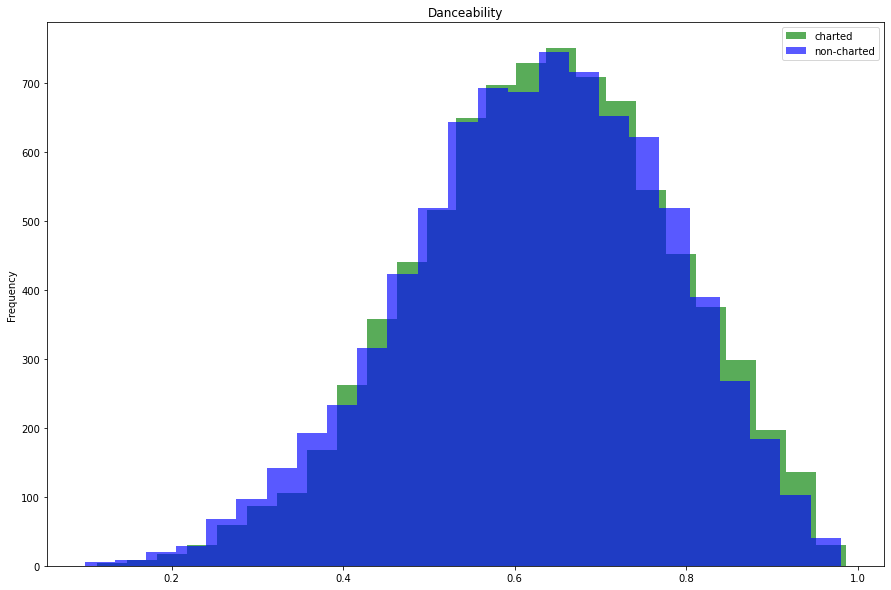

In [324]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
attr_class[lambda x: x.chart > 0].plot(kind="hist", y="danceability", bins=25, ax=ax, color="g", alpha=.65, label="charted", title="Danceability")
attr_class[lambda x: x.chart <= 0].sample(8305).plot(kind="hist", y="danceability", bins=25, ax=ax, color="b", alpha=.65, label="non-charted")

<AxesSubplot:title={'center':'Valence'}, ylabel='Frequency'>

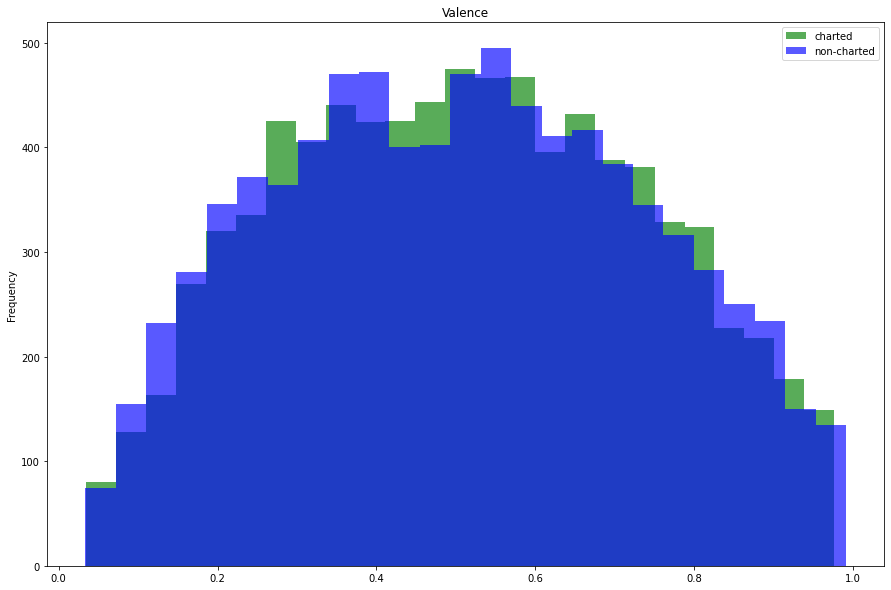

In [323]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
attr_class[lambda x: x.chart > 0].plot(kind="hist", y="valence", bins=25, ax=ax, color="g", alpha=.65, label="charted", title="Valence")
attr_class[lambda x: x.chart <= 0].sample(8305).plot(kind="hist", y="valence", bins=25, ax=ax, color="b", alpha=.65, label="non-charted")

<AxesSubplot:title={'center':'Speechiness'}, ylabel='Frequency'>

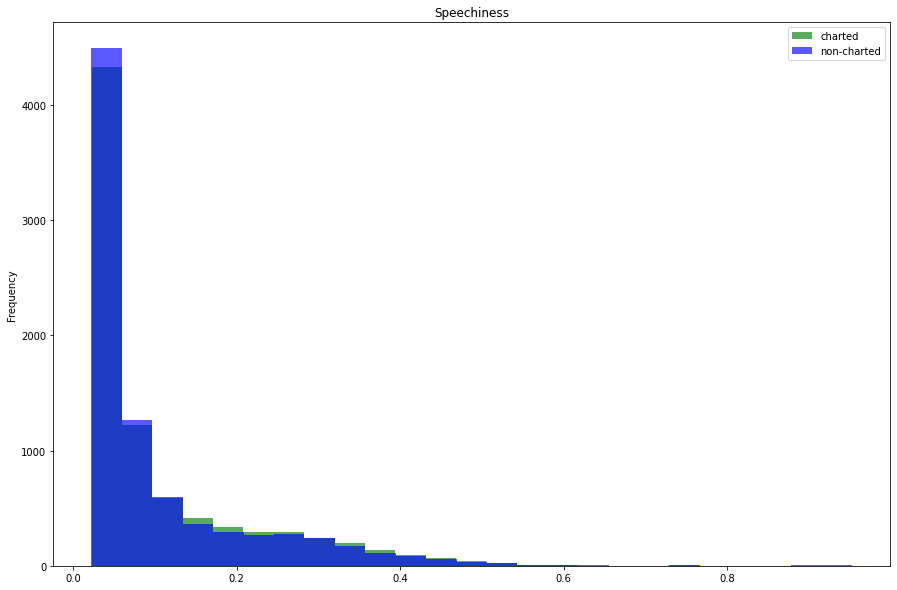

In [322]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
attr_class[lambda x: x.chart > 0].plot(kind="hist", y="speechiness", bins=25, ax=ax, color="g", alpha=.65, label="charted", title="Speechiness")
attr_class[lambda x: x.chart <= 0].sample(8305).plot(kind="hist", y="speechiness", bins=25, ax=ax, color="b", alpha=.65, label="non-charted")

<AxesSubplot:title={'center':'Tempo'}, ylabel='Frequency'>

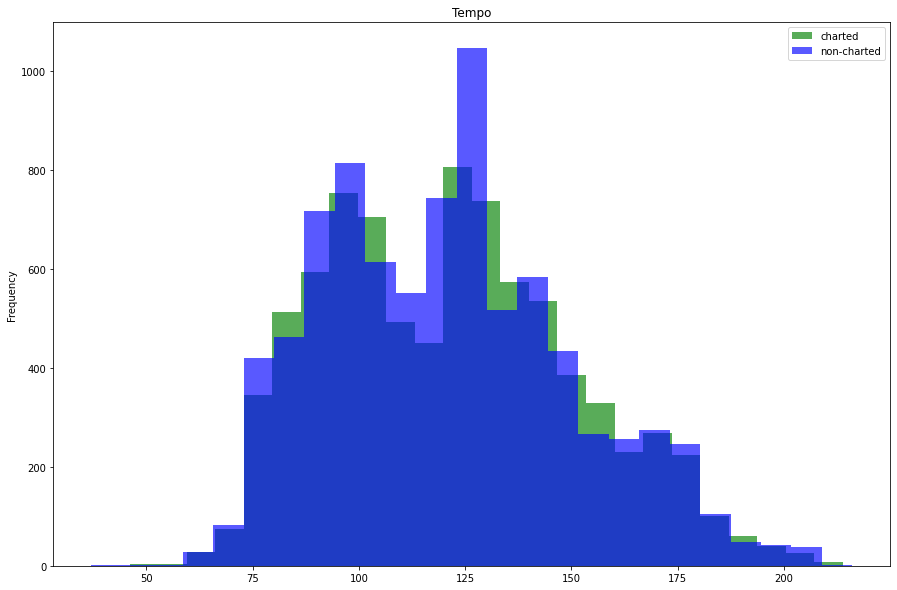

In [320]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
attr_class[lambda x: x.chart > 0].plot(kind="hist", y="tempo", bins=25, ax=ax, color="g", alpha=.65, label="charted", title="Tempo")
attr_class[lambda x: x.chart <= 0].sample(8305).plot(kind="hist", y="tempo", bins=25, ax=ax, color="b", alpha=.65, label="non-charted")

In [327]:
df_class_and_attr.loc[:, ["Song", "Performer", "genre_super", "knn", "svm", "decision_tree", "random_forest"]].dropna()

,Song,Performer,genre_super,knn,svm,decision_tree,random_forest
0,i'm your angel,r. kelly & celine dion,r&b,pop,pop,pop,pop
1,nobody's supposed to be here,deborah cox,r&b,r&b,pop,r&b,r&b
2,lately,divine,pop,country,country,soundtrack,pop
3,...baby one more time,britney spears,pop,pop,pop,pop,pop
4,because of you,98 degrees,pop,pop,country,pop,pop
...,...,...,...,...,...,...,...
21902,Soon as I Get Home,Faith Evans,r&b,country,pop,r&b,r&b
21903,Be Without You - Kendu Mix,Mary J. Blige,r&b,rap,rap,r&b,r&b
21904,Swing My Way,K.P. & Envyi,rap,pop,pop,rock,pop
21905,Yoü And I,Lady Gaga,pop,country,country,pop,pop


In [342]:
attr_class.assign(bin = lambda x: (x.genre_super == x.random_forest).astype("int")).bin.mean()

0.8360162342104063

In [343]:
attr_class.assign(bin = lambda x: (x.genre_super == x.decision_tree).astype("int")).bin.mean()

0.7856719412649915

In [344]:
attr_class.assign(bin = lambda x: (x.genre_super == x.svm).astype("int")).bin.mean()

0.5027589037347804

In [362]:
attr_class.assign(bin = lambda x: (x.genre_super == x.knn).astype("int")).bin.mean()

0.5064526426193625

In [490]:
Song = classifies_df.iloc[:, 0].values
Performer = classifies_df.iloc[:, 1].values

In [491]:
chart_classes_ = pd.DataFrame(zip(Song, Performer, knn_chart.predict(X), clf_chart.predict(X), rf_chart.predict(X), clf_sv_chart.predict(X), y), columns=["Song", "Performer","knn", "decision_tree", "random_forest", "svm","chart"])

In [494]:
genre_classes_ = pd.DataFrame(zip(Song, Performer, rf_genre_w_pop.predict(X_2), clf_genre_w_pop.predict(X_2), rf_genre_w_pop.predict(X_2), clf_sv_genre_w_pop.predict(X_2), y_2), columns=["Song", "Performer","knn", "decision_tree", "random_forest", "svm","genre"])

In [507]:
classes = chart_classes_.merge(genre_classes_, "inner",on=["Song", "Performer"], suffixes=('_chart', '_genre'))

In [517]:
classes.assign(bin = lambda x: (x.chart == x.knn_chart).astype("int")).bin.mean()

0.7310728791128553

In [518]:
classes.assign(bin = lambda x: (x.genre == x.knn_genre).astype("int")).bin.mean()

0.847944142746315

In [519]:
classes.assign(bin = lambda x: (x.chart == x.svm_chart).astype("int")).bin.mean()

0.6389357915392689

In [520]:
classes.assign(bin = lambda x: (x.genre == x.svm_genre).astype("int")).bin.mean()

0.4306119654999315

In [521]:
classes.assign(bin = lambda x: (x.chart == x.decision_tree_chart).astype("int")).bin.mean()

0.8557477296581938

In [522]:
classes.assign(bin = lambda x: (x.genre == x.decision_tree_genre).astype("int")).bin.mean()

0.7989777757495551

In [523]:
classes.assign(bin = lambda x: (x.chart == x.random_forest_chart).astype("int")).bin.mean()

0.888468032674668

In [524]:
classes.assign(bin = lambda x: (x.genre == x.random_forest_genre).astype("int")).bin.mean()

0.847944142746315

In [526]:
classes.head()

,Song,Performer,knn_chart,decision_tree_chart,random_forest_chart,svm_chart,chart,knn_genre,decision_tree_genre,random_forest_genre,svm_genre,genre
0,i'm your angel,r. kelly & celine dion,1.0,1.0,0.0,0.0,1.0,country,r&b,country,pop,r&b
1,nobody's supposed to be here,deborah cox,0.0,1.0,1.0,0.0,1.0,r&b,r&b,r&b,pop,r&b
2,lately,divine,1.0,0.0,0.0,0.0,1.0,country,country,country,pop,pop
3,...baby one more time,britney spears,1.0,1.0,1.0,1.0,1.0,pop,pop,pop,pop,pop
4,because of you,98 degrees,0.0,0.0,0.0,0.0,1.0,r&b,pop,r&b,pop,pop


In [527]:
classes = classes.drop(["chart", "genre"], axis=1)

In [528]:
classes

,Song,Performer,knn_chart,decision_tree_chart,random_forest_chart,svm_chart,knn_genre,decision_tree_genre,random_forest_genre,svm_genre
0,i'm your angel,r. kelly & celine dion,1.0,1.0,0.0,0.0,country,r&b,country,pop
1,nobody's supposed to be here,deborah cox,0.0,1.0,1.0,0.0,r&b,r&b,r&b,pop
2,lately,divine,1.0,0.0,0.0,0.0,country,country,country,pop
3,...baby one more time,britney spears,1.0,1.0,1.0,1.0,pop,pop,pop,pop
4,because of you,98 degrees,0.0,0.0,0.0,0.0,r&b,pop,r&b,pop
...,...,...,...,...,...,...,...,...,...,...
21908,Soon as I Get Home,Faith Evans,0.0,0.0,0.0,0.0,pop,pop,pop,pop
21909,Be Without You - Kendu Mix,Mary J. Blige,0.0,0.0,0.0,0.0,pop,pop,pop,pop
21910,Swing My Way,K.P. & Envyi,0.0,0.0,0.0,0.0,pop,pop,pop,pop
21911,Yoü And I,Lady Gaga,0.0,1.0,1.0,0.0,pop,pop,pop,pop


In [529]:
# with engine.connect() as con:
#     classes.to_sql("classes", con=con, index=False, if_exists="replace")